In [5]:
video_folder_path = 'prostate_paper_img/original'
mask_folder_path = 'prostate_paper_labels/original'


In [6]:
import os
from PIL import Image
import numpy as np

def load_video_frames_for_3d(folder_path, grayscale=False):
    frame_files = sorted([
        os.path.join(folder_path, f)
        for f in os.listdir(folder_path)
        if f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ])

    frames = []
    for f in frame_files:
        img = Image.open(f)
        if grayscale:
            img = img.convert("L")
        else:
            img = img.convert("RGB")
        frames.append(np.array(img)/255)

    frames = np.stack(frames, axis=0)
    if grayscale and frames.ndim == 3:
        frames = frames[..., None]

    return frames


video_frames = load_video_frames_for_3d(video_folder_path, grayscale=True)
num_frames, height, width, _ = video_frames.shape

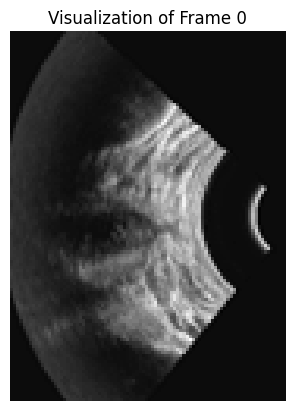

In [7]:
import matplotlib.pyplot as plt

frame_index = 0
if frame_index < len(video_frames):
    frame_to_display = video_frames[frame_index]
    if frame_to_display.shape[-1] == 1:
        frame_to_display = frame_to_display.squeeze(-1)
    plt.imshow(frame_to_display, cmap='gray')
    plt.title(f"Visualization of Frame {frame_index}")
    plt.axis('off')
    plt.show()
else:
    print(f"Frame index {frame_index} is out of bounds. The video has {len(video_frames)} frames.")

In [20]:
import torch
from torch.utils.data import Dataset

class VideoDataset(Dataset):
    def __init__(self, video_folder_path, grayscale=True):
        super().__init__()
        self.video_frames = load_video_frames_for_3d(video_folder_path, grayscale=grayscale)
        self.num_frames, self.height, self.width, self.channels = self.video_frames.shape
        self.coords_single_frame = self.get_mgrid_original_size(self.width, self.height)
        self.time_coords = torch.linspace(0, 1, self.num_frames)
        self.pixels = torch.tensor(self.video_frames, dtype=torch.float32).view(-1, self.channels)

    def get_mgrid_original_size(self, width, height):
        y = torch.linspace(0, 1, steps=height)
        x = torch.linspace(0, 1, steps=width)
        mgrid = torch.stack(torch.meshgrid(y, x, indexing='ij'), dim=-1)  # shape (H, W, 2)
        return mgrid.reshape(-1, 2)


    def __len__(self):
        return self.num_frames * self.height * self.width

    def __getitem__(self, idx):
        frame_idx = idx // (self.height * self.width)
        pixel_idx_in_frame = idx % (self.height * self.width)
        coord_xy = self.coords_single_frame[pixel_idx_in_frame]
        time_coord = self.time_coords[frame_idx].unsqueeze(-1)
        input_coords = torch.cat((coord_xy, time_coord), dim=-1)
        ground_truth_pixel = self.pixels[idx]
        return input_coords, ground_truth_pixel

In [21]:
video_dataset = VideoDataset(video_folder_path, grayscale=True)
first_input, first_gt = video_dataset[2]
print("Input coordinates (x, y, t):", first_input)
print("Ground truth pixel value:", first_gt)
print("Total number of samples:", len(video_dataset))

Input coordinates (x, y, t): tensor([0.0000, 0.0230, 0.0000])
Ground truth pixel value: tensor([0.0471])
Total number of samples: 841104


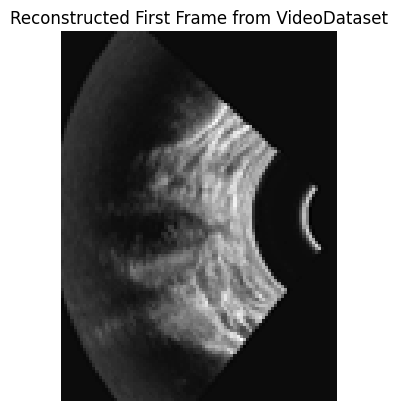

In [24]:
height = video_dataset.height
width = video_dataset.width
channels = video_dataset.channels


first_frame_pixels_flat = video_dataset.pixels[:height * width]


if channels == 1:
    reconstructed_frame = first_frame_pixels_flat.view(height, width).detach().numpy()
    cmap = 'gray'
else:
    reconstructed_frame = first_frame_pixels_flat.view(height, width, channels).detach().numpy()
    cmap = None


plt.imshow(reconstructed_frame, cmap=cmap)
plt.title("Reconstructed First Frame from VideoDataset")
plt.axis('off')
plt.show()

In [130]:
from typing import Optional, Callable, Union, Dict, List
import numpy as np
import torch
from torch import Tensor, nn

class SpatialDistortion:
    def __call__(self, x: Tensor) -> Tensor:
        return x


class HashEncoding(nn.Module):
    def __init__(self, in_dim: int = 3, num_levels: int = 4, features_per_level: int = 8):
        super().__init__()
        self.in_dim = in_dim
        self.num_levels = num_levels
        self.features_per_level = features_per_level
        self.freq_bands = 2.0 ** torch.linspace(0, num_levels - 1, num_levels)

    def forward(self, x: Tensor) -> Tensor:
        outs = [x]
        for f in self.freq_bands:
            outs.append(torch.sin(x * f * np.pi))
            outs.append(torch.cos(x * f * np.pi))
        return torch.cat(outs, dim=-1)


class SplashEncoding(nn.Module):
    def __init__(
        self,
        n_gausses: int = 10000,
        n_features_per_gauss: int = 32,
        knn_algorithm: Optional[object] = None,
        means: Optional[Tensor] = None,
        densify: bool = True,
        prune: bool = True,
        unfreeze_means: bool = True,
        spatial_distortion: Optional[SpatialDistortion] = None,
        device: str = "cuda" if torch.cuda.is_available() else "cpu",
        empty_as_hash: bool = False,
    ):
        super().__init__()
        assert knn_algorithm is not None, "KNN algorithm must be provided"

        self.device = device
        self.n_features_per_gauss = n_features_per_gauss
        self.densify_gausses = densify
        self.prune_gausses = prune
        self.unfreeze_gausses = unfreeze_means
        self.empty_as_hash = empty_as_hash
        self.spatial_distortion = spatial_distortion or SpatialDistortion()

        if means is not None:
            if isinstance(means, np.ndarray):
                means = torch.tensor(means, dtype=torch.float32, device=self.device)
            else:
                means = means.to(self.device)
        else:
            means = self.init_mean(n_gausses)

        self.total_gaus = means.shape[0]
        means = nn.Parameter(means, requires_grad=False)

        self.hash_encoding = HashEncoding(in_dim=3)
        self.means_hash = HashEncoding(in_dim=3)

        self.register_buffer("feats", self.means_hash(means))
        log_covs = nn.Parameter(torch.log(torch.ones(self.total_gaus, 3, device=self.device) * 0.0001))
        self.confidence = torch.ones(self.total_gaus, device=self.device)

        self.gauss_params = nn.ParameterDict({
            "means": means,
            "log_covs": log_covs
        })

        self.knn = knn_algorithm

    def init_mean(self, N: int) -> Tensor:
        print(f"Initializing {N} Gaussian centers...")
        pts = np.random.randn(N, 3)
        r = np.sqrt(np.random.rand(N, 1))
        pts = pts / np.linalg.norm(pts, axis=1)[:, None] * r
        pts = pts * 0.5 + 0.5
        return torch.tensor(pts, device=self.device).to(torch.float32)


    def unfreeze_means(self):
        if self.unfreeze_gausses:
            self.gauss_params["means"].requires_grad_(True)

    def freeze_means(self):
        if self.unfreeze_gausses:
            self.gauss_params["means"].requires_grad_(False)

    def _update_param_with_optimizer(
        self,
        param_fn: Callable[[str, Tensor], Tensor],
        optimizer_fn: Callable[[str, Tensor], Tensor],
        params: Union[Dict[str, torch.nn.Parameter], torch.nn.ParameterDict],
        optimizers: Dict[str, torch.optim.Optimizer],
        names: Union[List[str], None] = None,
    ):
        """Update the parameters and the state in the optimizers with defined functions.

        Args:
            param_fn: A function that takes the name of the parameter and the parameter itself,
                and returns the new parameter.
            optimizer_fn: A function that takes the key of the optimizer state and the state value,
                and returns the new state value.
            params: A dictionary of parameters.
            optimizers: A dictionary of optimizers, each corresponding to a parameter.
            names: A list of key names to update. If None, update all. Default: None.
        """
        if names is None:
            # If names is not provided, update all parameters
            names = list(params.keys())

        for name in names:
            param = params[name]
            new_param = param_fn(name, param)
            params[name] = new_param
            if name not in optimizers:
                assert not param.requires_grad, (
                    f"Optimizer for {name} is not found, but the parameter is trainable."
                    f"Got requires_grad={param.requires_grad}"
                )
                continue
            optimizer = optimizers[name]['optimizer']
            for i in range(len(optimizer.param_groups)):
                param_state = optimizer.state[param]
                del optimizer.state[param]
                for key in param_state.keys():
                    if key != "step":
                        v = param_state[key]
                        param_state[key] = optimizer_fn(key, v)
                optimizer.param_groups[i]["params"] = [new_param]
                optimizer.state[new_param] = param_state
                
    def prune(self, optimizers: Dict[str, torch.optim.Optimizer], threshold: float=0.1):
        """
        Remove all means, feats, log_covs, and confidence entries with confidence lower than threshold.
        """
        if self.prune_gausses:
            mask = self.confidence >= threshold
            def param_fn(name: str, p: Tensor) -> Tensor:
                return torch.nn.Parameter(p[mask], requires_grad=p.requires_grad)

            def optimizer_fn(key: str, v: Tensor) -> Tensor:
                return v[mask]
                
            self._update_param_with_optimizer(param_fn, optimizer_fn, self.gauss_params, optimizers)

            # Only keep entries where mask is True
            self.confidence = self.confidence[mask]
            self.total_gaus = self.means.shape[0]
            self.feats = self.means_hash(self.means)
            # Refit KNN with new means
            print(f"Pruned to {self.means.shape[0]} gaussians.")

    
    @property
    def means(self) -> Tensor:
        return self.gauss_params["means"]

    @property
    def log_covs(self) -> Tensor:
        return self.gauss_params["log_covs"]

    def get_out_dim(self) -> int:
        return self.n_features_per_gauss


    def interpolate(self, coords: Tensor, nearest_gauss_indices: Tensor) -> Tensor:
        if self.training:
            with torch.no_grad():
                self.feats.copy_(self.means_hash(self.means))


        nearest_features = self.feats[nearest_gauss_indices]
        nearest_covs = torch.exp(self.log_covs[nearest_gauss_indices])

        diff = coords[:, None, :] - self.means[nearest_gauss_indices]
        
        eps = 1e-6
        mdist = ((diff ** 2) / (nearest_covs + eps)).sum(-1)
        gau_weights = torch.exp(-0.5 * mdist).clamp_min(1e-8)

        weighted_features = nearest_features * gau_weights.unsqueeze(-1)

        return torch.sum(weighted_features, dim=1)


    def forward(self, coords: Tensor) -> Tensor:
        coords = self.spatial_distortion(coords)
        with torch.no_grad():
          self.knn.fit(self.means)
          nearest_indices, _ = self.knn.get_nearest_neighbours(coords)
          nearest_indices = torch.tensor(nearest_indices, device=self.device, dtype=torch.long)
          nearest_indices = torch.clamp(nearest_indices, 0, self.means.shape[0] - 1)

        splash_feats = self.interpolate(coords, nearest_indices)
        if self.empty_as_hash:
            hash_feats = self.hash_encoding(coords)
            mask = (nearest_indices > 0).all(dim=1)
            feats = torch.where(mask.unsqueeze(-1), splash_feats, hash_feats)
        else:
            feats = splash_feats

        if self.training:
            self.confidence -= 0.001
            self.confidence[nearest_indices] += 0.01
            self.confidence.clamp_(0.0, 1.0)
        return feats


In [131]:
from typing import Literal, Optional, Set, Tuple

import torch
from torch import Tensor, nn

class MLP(nn.Module):
    def __init__(
        self,
        in_dim: int,
        num_layers: int,
        layer_width: int,
        out_dim: Optional[int] = None,
        activation: Optional[nn.Module] = nn.ReLU(),
        out_activation: Optional[nn.Module] = None,
    ) -> None:
        super().__init__()
        assert in_dim > 0
        self.in_dim = in_dim
        self.num_layers = num_layers
        self.layer_width = layer_width
        self.out_dim = out_dim if out_dim is not None else layer_width
        self.activation = activation
        self.out_activation = out_activation

        self.build_nn_modules()

    def build_nn_modules(self) -> None:
        layers = []
        for i in range(self.num_layers):
            input_dim = self.in_dim if i == 0 else self.layer_width
            output_dim = self.out_dim if i == self.num_layers - 1 else self.layer_width
            layers.append(nn.Linear(input_dim, output_dim))
        self.layers = nn.ModuleList(layers)

    def forward(self, x: Tensor) -> Tensor:
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers) - 1 and self.activation is not None:
                x = self.activation(x)
        if self.out_activation is not None:
            x = self.out_activation(x)
        return x

class MLPWithHashEncoding(nn.Module):
    def __init__(
        self,
        knn_algorithm: Optional[object] = None,
        n_features_per_gauss: int = 27,
        num_layers: int = 2,
        layer_width: int = 64,
        out_dim: Optional[int] = None,
        skip_connections: Optional[Tuple[int]] = None,
        activation: Optional[nn.Module] = nn.ReLU(),
        out_activation: Optional[nn.Module] = None,
        seed_points: Optional[Tensor] = None,
        densify: bool = True,
        prune: bool = True,
        unfreeze_means: bool = True,
        spatial_distortion: Optional[SpatialDistortion] = None,
    ) -> None:
        super().__init__()

        self.in_dim = 3
        self.encoder = SplashEncoding(
            n_features_per_gauss=n_features_per_gauss,
            n_gausses=100000,
            knn_algorithm=knn_algorithm,
            means=seed_points,
            densify=densify,
            prune=prune,
            unfreeze_means=unfreeze_means,
            spatial_distortion=spatial_distortion,
        )

        self.mlp = MLP(
            in_dim=self.encoder.get_out_dim(),
            num_layers=num_layers,
            layer_width=layer_width,
            out_dim=out_dim,
            activation=activation,
            out_activation=out_activation,
        )

    def forward(self, x: Tensor) -> Tensor:
        encoded = self.encoder(x)
        return self.mlp(encoded)

In [141]:
from torch.utils.data import DataLoader
from genie.knn.knn_algorithms import TorchKNNConfig, TorchKNN

knn_config = TorchKNNConfig()
knn = TorchKNN(knn_config)


mlp = MLPWithHashEncoding(knn_algorithm = knn,
                          out_dim = 1
                          ).cuda()

learning_rate_mlp = 0.0001
learning_rate_means = 0.001
learning_rate_covs = 0.001

num_epochs = 100
batch_size = 1024

# densification_start_step =
# denisification_interval = 
# densification_stop_step = 

pruning_start_step = 0
pruning_stop_step = 10000000
pruning_interval = 1000
unfreeze_means_step = 0
freeze_means_step = 10000000

criterion = torch.nn.MSELoss()

optimizer_mlp = torch.optim.Adam(mlp.mlp.parameters(), lr=learning_rate_mlp)
optimizer_gaussian_means = torch.optim.Adam([mlp.encoder.gauss_params["means"]], lr=learning_rate_means)
optimizer_gaussian_covs = torch.optim.Adam([mlp.encoder.gauss_params["log_covs"]], lr=learning_rate_covs)


optimizers={
            "fields": {
                "optimizer": optimizer_mlp,
            },
            "means": {
                "optimizer": optimizer_gaussian_means,
            },
            "log_covs": {
                "optimizer": optimizer_gaussian_covs,
            },
        }


dataloader = DataLoader(video_dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp.to(device)

print("Starting training...")
        
global_step = 0
for epoch in range(num_epochs):
    print(global_step)
    mlp.train()
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        # if global_step >= densification_start_step and global_step % denisification_interval == 0 and global_step <= densification_stop_step:
            # model.densify_points(self.optimizers.optimizers)
            # densify_points = self.densify_buffer.to(device)
            # mlp.encoder.densify(densify_points, optimizers=optimizers)
        
        if global_step >= pruning_start_step and global_step % pruning_interval == 0 and global_step <= pruning_stop_step:
            mlp.encoder.prune(optimizers=optimizers)

        # if global_step == unfreeze_means_step:
        #     mlp.encoder.unfreeze_means()

        # if global_step == freeze_means_step:
        #     mlp.encoder.freeze_means()

        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        for key, val in optimizers.items():
            val["optimizer"].zero_grad()

        outputs = mlp(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        for key, val in optimizers.items():
            val["optimizer"].step()


        running_loss += loss.item()

        if global_step % 1000 == 0:
          print(inputs[0], labels[0].item(), outputs[0].item())
        global_step += 1

    
    epoch_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

print("Training finished.")

Initializing 100000 Gaussian centers...
Starting training...
0
Pruned to 100000 gaussians.
tensor([0.2564, 0.3908, 0.2875], device='cuda:0') 0.5607843399047852 -0.7015634775161743


/net/tscratch/people/plgmarzol/slurm_jobdir/2055523/tmp.t0045/ipykernel_2429980/393886070.py:197: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nearest_indices = torch.tensor(nearest_indices, device=self.device, dtype=torch.long)


Epoch [1/100], Loss: 0.0717
822
Pruned to 99404 gaussians.
tensor([0.0513, 0.3448, 0.6250], device='cuda:0') 0.27450981736183167 0.19482064247131348
Epoch [2/100], Loss: 0.0283
1644
Pruned to 78132 gaussians.
tensor([0.3761, 0.0460, 0.3125], device='cuda:0') 0.19607843458652496 0.15231087803840637
Epoch [3/100], Loss: 0.0270
2466
Pruned to 69092 gaussians.
tensor([0.4615, 0.7011, 0.5375], device='cuda:0') 0.0470588244497776 0.1760316789150238
Epoch [4/100], Loss: 0.0273
3288
Pruned to 67172 gaussians.
tensor([0.8376, 0.9655, 0.2500], device='cuda:0') 0.04313725605607033 0.16733309626579285
Epoch [5/100], Loss: 0.0259
4110
Epoch [6/100], Loss: 0.0239
4932
Pruned to 66133 gaussians.
tensor([0.8291, 0.3103, 0.1500], device='cuda:0') 0.08627451211214066 0.17104671895503998
Epoch [7/100], Loss: 0.0220
5754
Pruned to 65407 gaussians.
tensor([0.1368, 0.4943, 1.0000], device='cuda:0') 0.12156862765550613 0.15141896903514862
Epoch [8/100], Loss: 0.0200
6576
Pruned to 64897 gaussians.
tensor([0.

/net/tscratch/people/plgmarzol/slurm_jobdir/2055523/tmp.t0045/ipykernel_2429980/393886070.py:197: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nearest_indices = torch.tensor(nearest_indices, device=self.device, dtype=torch.long)


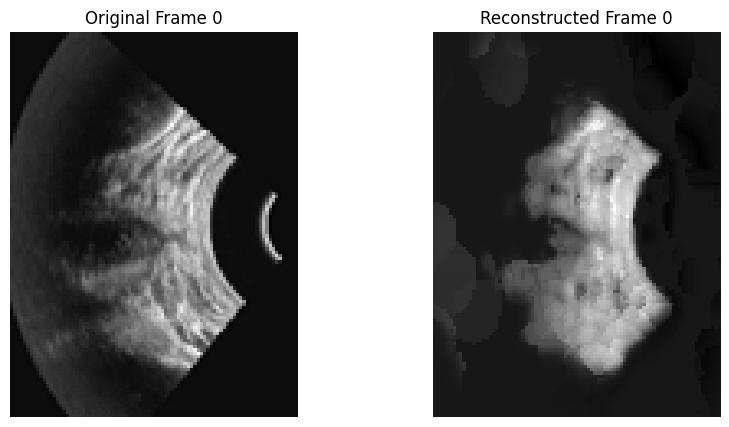

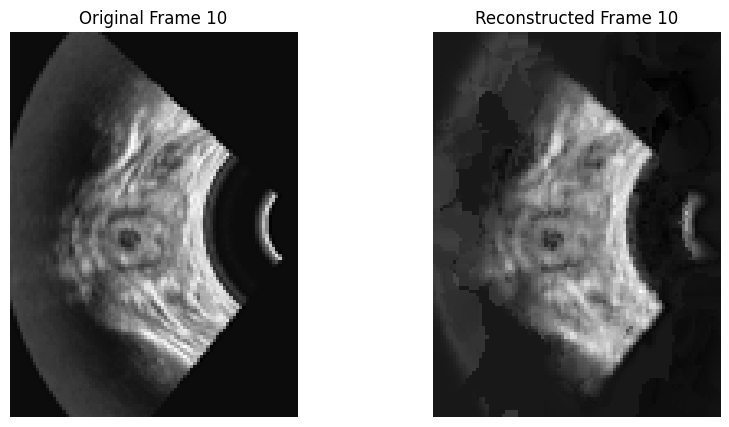

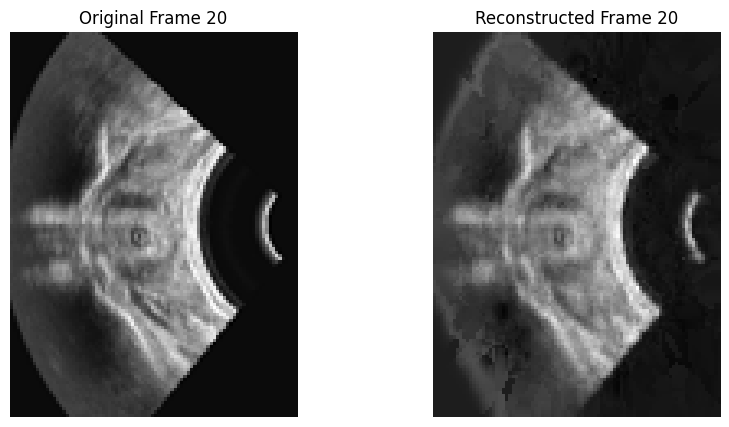

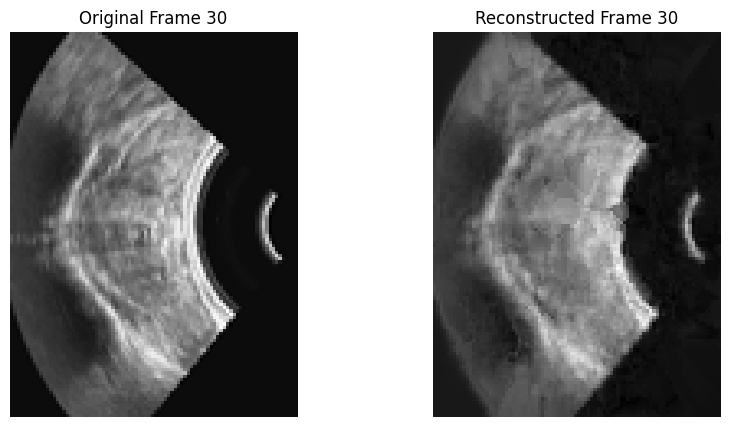

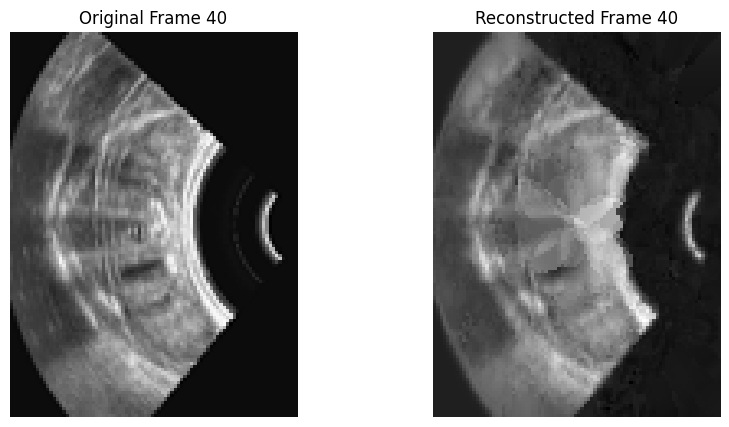

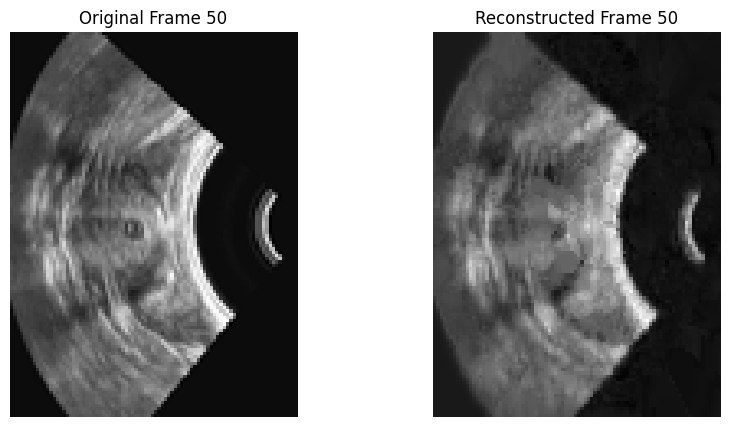

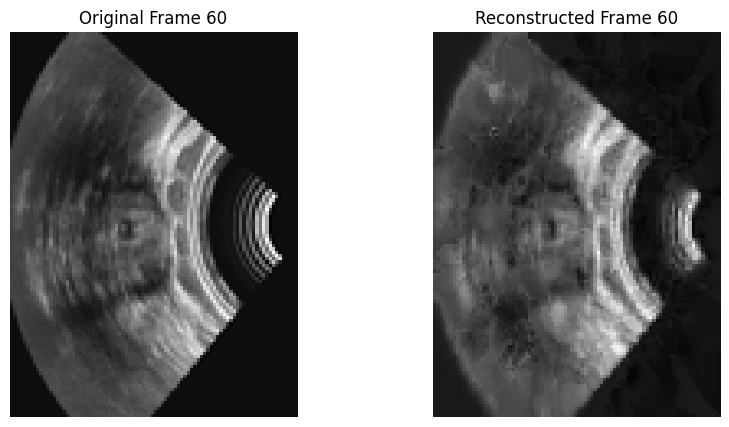

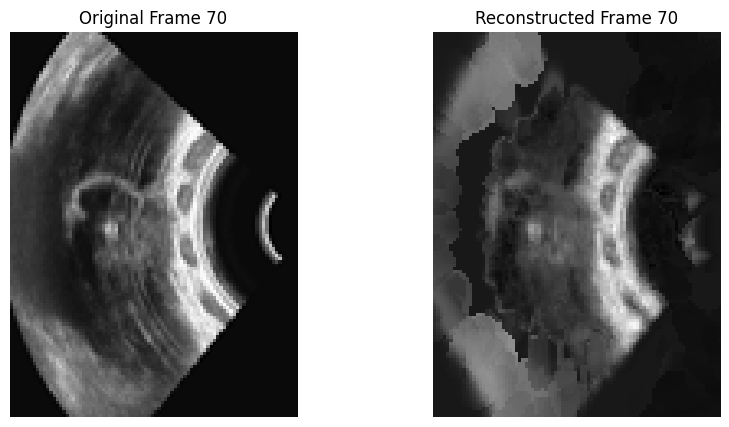

In [144]:
mlp.eval()
frame_index_to_reconstruct =  30

for frame_index_to_reconstruct in range(0,80, 10):
    if frame_index_to_reconstruct < len(video_frames):
        height = video_dataset.height
        width = video_dataset.width
        time_coord_for_frame = video_dataset.time_coords[frame_index_to_reconstruct].unsqueeze(-1)
        coords_single_frame = video_dataset.coords_single_frame
        input_coords_for_frame = torch.cat((coords_single_frame, time_coord_for_frame.expand(coords_single_frame.shape[0], -1)), dim=-1)
    
    
        input_coords_for_frame = input_coords_for_frame.to(device)
        with torch.no_grad():
            reconstructed_pixels_flat = mlp(input_coords_for_frame)
    
        if video_dataset.channels == 1:
            reconstructed_frame = reconstructed_pixels_flat.view(height, width).cpu().numpy()
            cmap = 'gray'
        else:
            reconstructed_frame = reconstructed_pixels_flat.view(height, width, video_dataset.channels).cpu().numpy()
            cmap = None
    
    
        plt.figure(figsize=(10, 5))
    
        plt.subplot(1, 2, 1)
        original_frame = video_frames[frame_index_to_reconstruct].squeeze(-1) if video_dataset.channels == 1 else video_frames[frame_index_to_reconstruct]
        plt.imshow(original_frame, cmap=cmap)
        plt.title(f"Original Frame {frame_index_to_reconstruct}")
        plt.axis('off')
    
        plt.subplot(1, 2, 2)
        plt.imshow(reconstructed_frame, cmap=cmap)
        plt.title(f"Reconstructed Frame {frame_index_to_reconstruct}")
        plt.axis('off')
        plt.show()
    
    else:
        print(f"Frame index {frame_index_to_reconstruct} is out of bounds. The video has {len(video_frames)} frames.")

In [198]:
import torch
import matplotlib.pyplot as plt

def reconstruct_frame_at_time(mlp, video_dataset, video_frames, time, device='cuda'):
    mlp.eval()

    time_coords = video_dataset.time_coords.squeeze(-1)
    frame_index = (torch.abs(time_coords - time)).argmin().item()
    
    height = video_dataset.height
    width = video_dataset.width
    coords_single_frame = video_dataset.coords_single_frame
    
    exact_time_coord = torch.tensor([[time]], dtype=video_dataset.time_coords.dtype)
    input_coords_for_frame_exact = torch.cat((coords_single_frame, exact_time_coord.expand(coords_single_frame.shape[0], -1)),dim=-1).to(device)
    
    input_coords_for_frame_exact = torch.cat(
        (coords_single_frame, exact_time_coord.expand(coords_single_frame.shape[0], -1)),
        dim=-1
    ).to(device)

    
    closest_time_coord = video_dataset.time_coords[frame_index].unsqueeze(-1)
    input_coords_for_frame_closest = torch.cat((coords_single_frame, closest_time_coord.expand(coords_single_frame.shape[0], -1)), dim=-1 ).to(device)

    
    with torch.no_grad():
        reconstructed_pixels_flat_exact = mlp(input_coords_for_frame_exact)
        reconstructed_frame_exact = reconstructed_pixels_flat_exact.view(height, width).cpu().numpy()

        reconstructed_pixels_flat_closest = mlp(input_coords_for_frame_closest)
        reconstructed_frame_closest = reconstructed_pixels_flat_closest.view(height, width).cpu().numpy()
        
        cmap = 'gray'

    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    original_frame = video_frames[frame_index].squeeze(-1) if video_dataset.channels == 1 else video_frames[frame_index]
    plt.imshow(original_frame, cmap=cmap)
    plt.title(f"Nearest Original Frame {frame_index} (time={time_coords[frame_index]:.4f})")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(reconstructed_frame_closest, cmap=cmap)
    plt.title(f"Reconstructed at y {time_coords[frame_index]:.4f}")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(reconstructed_frame_exact, cmap=cmap)
    plt.title(f"Reconstructed at x {time:.4f}")
    plt.axis('off')

    
    plt.show()


/net/tscratch/people/plgmarzol/slurm_jobdir/2055523/tmp.t0045/ipykernel_2429980/393886070.py:197: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nearest_indices = torch.tensor(nearest_indices, device=self.device, dtype=torch.long)


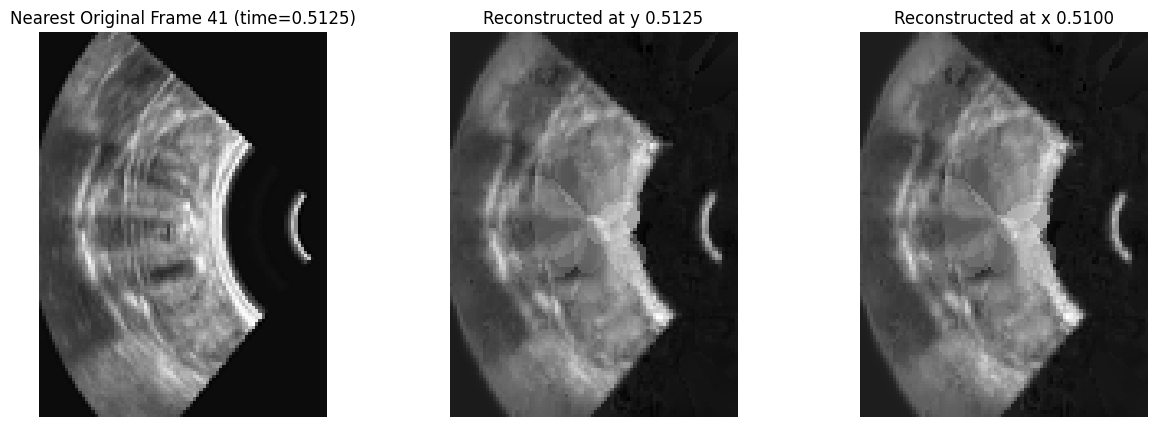

In [207]:
reconstruct_frame_at_time(mlp, video_dataset, video_frames, 0.51)

In [217]:
        # self.gauss_params = nn.ParameterDict({
        #     "means": means,
        #     "log_covs": log_covs
        # })

print(mlp.encoder.gauss_params.means.detach().cpu().shape)
print(torch.exp(mlp.encoder.gauss_params.log_covs.detach().cpu()).shape)

torch.Size([63170, 3])
torch.Size([63170, 3])


In [211]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def visualize_3d_gaussians(means, covariances=None, num_ellipsoids=100, alpha=0.3, color='blue'):
    means = np.array(means)
    N = len(means)
    
    if N == 0:
        print("No Gaussians to visualize.")
        return
    
    if covariances is None and scales is None:
        print("Provide either covariances or scales.")
        return
    
    if N > num_ellipsoids:
        idx = np.random.choice(N, num_ellipsoids, replace=False)
        means = means[idx]
        covariances = np.array(covariances)[idx]
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    u = np.linspace(0, 2 * np.pi, 20)
    v = np.linspace(0, np.pi, 10)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones_like(u), np.cos(v))
    sphere = np.stack([x, y, z], axis=-1)
    
    for i in range(len(means)):
        mu = means[i]
        if covariances is not None:
            cov = covariances[i]
            eigvals, eigvecs = np.linalg.eigh(cov)
            radii = np.sqrt(np.maximum(eigvals, 1e-8))
            transform = eigvecs @ np.diag(radii)
        else:
            transform = np.diag(scales[i])
        
        ellipsoid = sphere @ transform.T + mu
        ax.plot_surface(
            ellipsoid[..., 0], ellipsoid[..., 1], ellipsoid[..., 2],
            rstride=1, cstride=1, color=color, alpha=alpha, linewidth=0
        )
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('T')
    ax.set_title('3D Gaussian Latent Representation (Means + Covariances)')
    plt.tight_layout()
    plt.show()


LinAlgError: 1-dimensional array given. Array must be at least two-dimensional

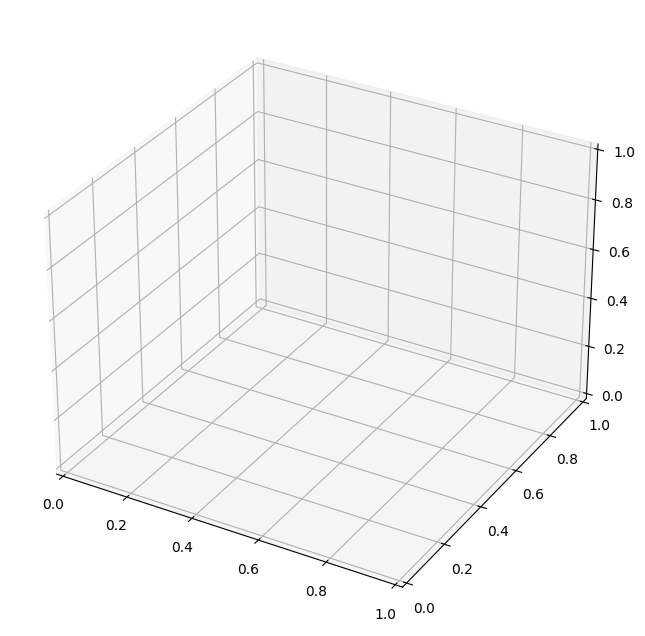

In [214]:
visualize_3d_gaussians(mlp.encoder.gauss_params.means.detach().cpu(), torch.exp(mlp.encoder.gauss_params.log_covs.detach().cpu()))